In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the mems dataset. 
# implemented svm Classifier. 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import time
import numpy as np
from sklearn.svm import SVC


2024-05-02 18:09:31.194450: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 18:09:31.232431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 18:09:31.907393: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT/IOT_Datasets/mems_dataset.csv')


# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21563 entries, 0 to 21575
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       21563 non-null  float64
 1   y       21563 non-null  float64
 2   z       21563 non-null  float64
 3   label   21563 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 842.3 KB


In [3]:
# X-axis: Represents acceleration along the horizontal axis.
# Y-axis: Represents acceleration along the vertical axis.
# Z-axis: Represents acceleration along the depth axis.

# labels 
#1. Normal: This label represents the state of the machine when it is operating under normal conditions, without any significant mechanical imbalance or impending failure.
#2. Near-failure: This label indicates that the machine is experiencing conditions that suggest it is close to a failure state. These conditions may include early signs of mechanical imbalance or other issues that could lead to failure if not addressed.
#3. Failure: This label is assigned when the machine has reached a state of failure, where it is no longer functioning as intended due to mechanical issues or other problems.


# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
1    10955
2     5771
3     4837
Name: count, dtype: int64


In [4]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [6]:
start_time = time.time()
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Initialize SVM classifier
    svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)


    start_train_time = time.time()
    # Train DT
    svm_classifier.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    start_pred_time = time.time()    
    # Make predictions 
    y_pred_encoded = svm_classifier.predict(X_test)
    pred_time = time.time() - start_pred_time

total_time = time.time() - start_time

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2024-05-02 18:09:32.592807: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:2.572900 seconds
Time taken for prediction: 0.757485 seconds
Total time taken:3.433214 seconds


In [8]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.664090276704282


In [9]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred_encoded))


Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.89      0.74      3287
           2       0.77      0.78      0.77      1731
           3       0.80      0.00      0.01      1451

    accuracy                           0.66      6469
   macro avg       0.73      0.56      0.51      6469
weighted avg       0.70      0.66      0.58      6469



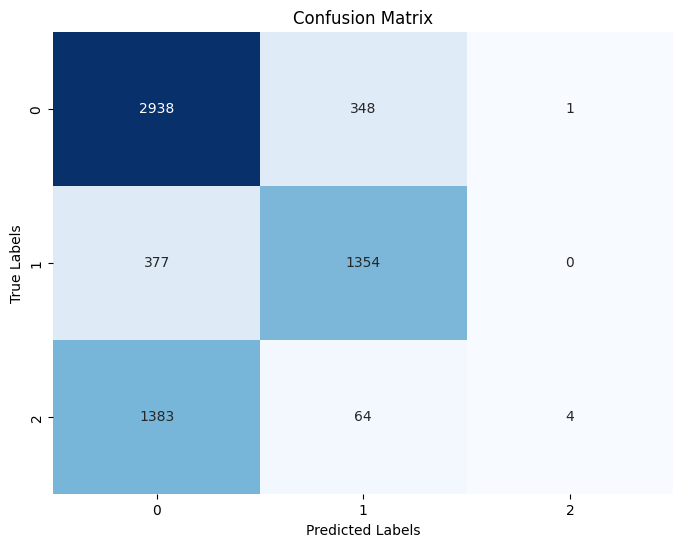

In [10]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_encoded)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

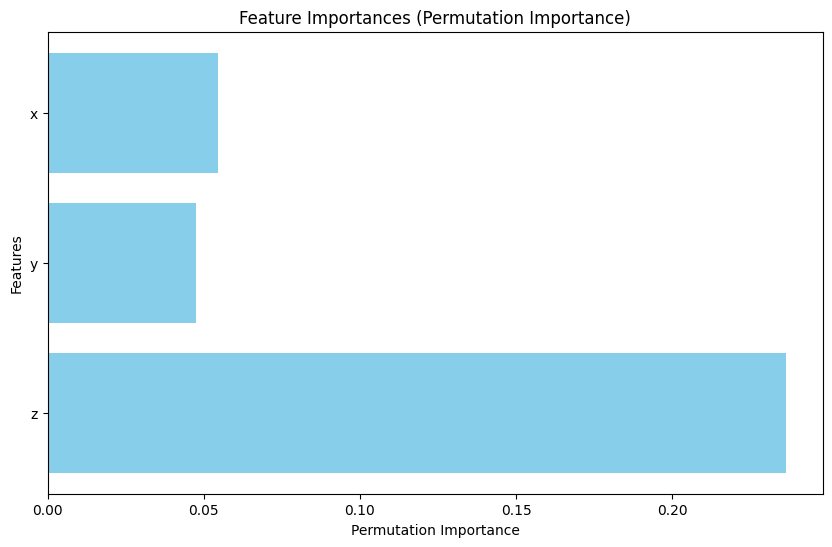

In [16]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(svm_classifier, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importances
feature_importance = perm_importance.importances_mean

# Map feature importances to feature names
feature_names = X.columns

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Feature Importances (Permutation Importance)')
plt.gca().invert_yaxis() 
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_encoded)
precision = precision_score(y_test, y_pred_encoded, average='macro')
recall = recall_score(y_test, y_pred_encoded, average='macro')
f1 = f1_score(y_test, y_pred_encoded, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print("Prediction Evaluation:")
print("Accuracy: {:f}".format(accuracy))
print("Precision: {:f}".format(precision))
print("Recall: {:f}".format(recall))
print("F1-score: {:f}".format(f1))
print("Confusion Matrix:")
print(conf_matrix)


Prediction Evaluation:
Accuracy: 0.664090
Precision: 0.730692
Recall: 0.559596
F1-score: 0.505251
Confusion Matrix:
[[2938  348    1]
 [ 377 1354    0]
 [1383   64    4]]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


svm_linear = SVC(kernel='linear')
svm_poly = SVC(kernel='poly', degree=3)
svm_rbf = SVC(kernel='rbf')
svm_sigmoid = SVC(kernel='sigmoid')


svm_linear.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)
svm_sigmoid.fit(X_train, y_train)

accuracy_linear = svm_linear.score(X_test, y_test)
accuracy_poly = svm_poly.score(X_test, y_test)
accuracy_rbf = svm_rbf.score(X_test, y_test)
accuracy_sigmoid = svm_sigmoid.score(X_test, y_test)

print("Accuracy (Linear Kernel):", accuracy_linear)
print("Accuracy (Polynomial Kernel):", accuracy_poly)
print("Accuracy (RBF Kernel):", accuracy_rbf)
print("Accuracy (Sigmoid Kernel):", accuracy_sigmoid)


Accuracy (Linear Kernel): 0.6625444427268511
Accuracy (Polynomial Kernel): 0.6596073581697326
Accuracy (RBF Kernel): 0.6405936002473335
Accuracy (Sigmoid Kernel): 0.5074972947905395
